### Imports

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms as T
from torch.utils.tensorboard import SummaryWriter
from scripts.data.dataset import DSLRDataset
from scripts.data.transforms import Resize, ToTensor, Normalize
from scripts.networks.nn_2d import MobileNetV3_Segmentation
from scripts.utils.load_save_models import save_checkpoint, get_latest_checkpoint, inference, load_checkpoint
from scripts.utils.visualizer import visualize_predictions, visualize_dataloader

# Set CUDA_LAUNCH_BLOCKING for accurate stack trace
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Clear GPU cache
torch.cuda.empty_cache()

# Set PYTORCH_CUDA_ALLOC_CONF to manage memory fragmentation
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:128'



### Prepare for Dataset

In [2]:
# Paths to dataset and split files
data_dir = 'dataset/data'
train_split_file = 'dataset/splits/nvs_sem_train.txt'
val_split_file = 'dataset/splits/nvs_sem_val.txt'

# Define the transforms
transform = T.Compose([
    Resize((448,672)),  # Resize to 224x336
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

### Dataset

In [3]:
# Create datasets and dataloaders
train_dataset = DSLRDataset(data_dir, train_split_file, transform=transform)
val_dataset = DSLRDataset(data_dir, val_split_file, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4)


### Visualize first

Visualizing data from the dataloader...
Loaded palette: [[0.40784314 0.8        1.        ]
 [0.7372549  0.74117647 0.13333333]
 [0.59607843 0.8745098  0.54117647]
 [1.         0.59607843 0.58823529]
 [0.83921569 0.15294118 0.15686275]]


/home/lukas/anaconda3/envs/d/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/lukas/anaconda3/envs/d/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, i

Input image shape: (448, 672, 3), min: 0.0, max: 1.0
Label image shape: (448, 672), unique values: [-100  -99  -98  -97  -96  -95  -94  -93  -92  -91  -90  -89  -88  -87
  -86  -85  -84  -83  -82  -81  -80  -79  -78  -77  -76  -75  -74  -73
  -72  -71  -70  -69  -68  -67  -66  -65  -64  -63  -62  -61  -60  -59
  -58  -57  -56  -55  -54  -53  -52  -51  -50  -49  -48  -47  -46  -45
  -44  -43  -42  -41  -40  -39  -38  -37  -36  -35  -34  -33  -32  -31
  -30  -29  -28  -27  -26  -25  -24  -23  -22  -21  -20  -19  -18  -17
  -16  -15  -14  -13  -12  -11  -10   -9   -8   -7   -6   -5   -4   -3
   -2   -1    0    1    2    3    4    5    6    7    8    9   10   11
   12   13   14   15   16   17   18   19   20   21   22   23   24   25
   26   27   30   36   37   46   47   48   51   52   55]
Input image shape: (448, 672, 3), min: 0.0, max: 1.0
Label image shape: (448, 672), unique values: [-100  -99  -98  -97  -96  -95  -94  -93  -92  -91  -90  -89  -88  -87
  -86  -85  -84  -83  -82  -81  -80

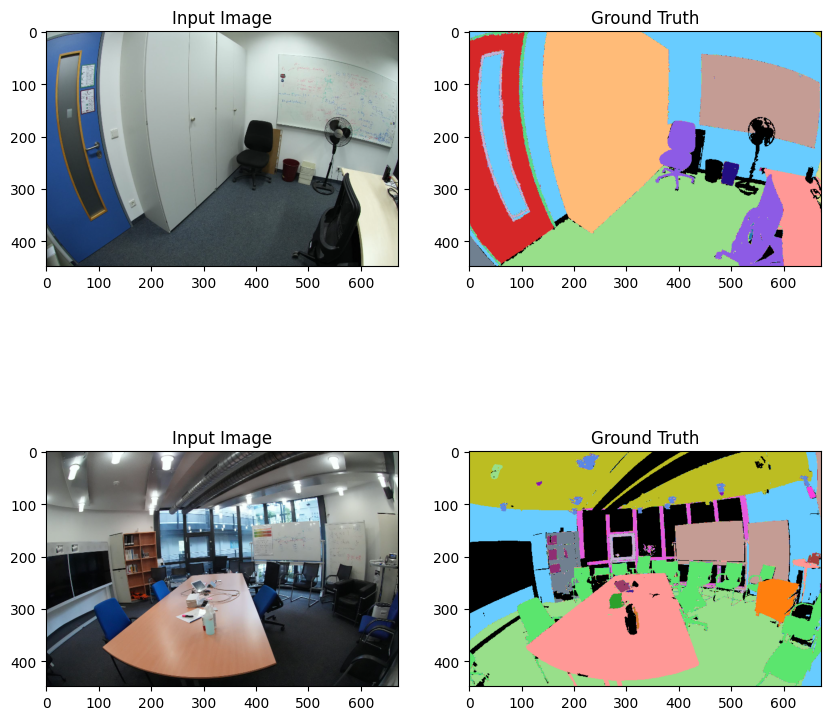

In [4]:
# Visualize data from the dataloader before training
print("Visualizing data from the dataloader...")
visualize_dataloader(val_loader, palette_file='scripts/utils/palette_scannet200.txt', num_samples=2)

### Training preparation

In [5]:
from scripts.networks.nn_2d import MobileNetV3_Segmentation
from scripts.networks.nn_2d_dino import DINOv2_Segmentation
from scripts.networks.nn_2d_segformer import Segformer_Segmentation

# # Instantiate the model and move it to the device: MobileNetV3_Segmentation
# model = MobileNetV3_Segmentation(num_classes=100).to(device)


# Instantiate the model and move it to the device: SegFormer

model = Segformer_Segmentation(num_classes=101)

# model to device
model = model.to(device)



# Define the ignore index for invalid labels
IGNORE_INDEX = -1

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=IGNORE_INDEX)
optimizer = optim.Adam(model.parameters(), lr=0.001)


# Check the model architecture
print(model)
# Initialize TensorBoard SummaryWriter
writer = SummaryWriter(log_dir='./runs')




################Deprecated################
# # Instantiate the model and move it to the device: Dinov2 (Deprecated for it only returns CLS token, but I have labels, no need for it to tell segment head what class is)
# model = DINOv2_Segmentation(num_classes=100).to(device)

/home/lukas/anaconda3/envs/d/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/lukas/anaconda3/envs/d/lib/python3.9/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


Segformer_Segmentation(
  (backbone): SegformerModel(
    (encoder): SegformerEncoder(
      (patch_embeddings): ModuleList(
        (0): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(3, 32, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        )
        (1): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (2): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(64, 160, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
        )
        (3): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(160, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        )
   

### Load the latest

In [6]:
from scripts.utils.load_save_models import get_latest_checkpoint
# Create the checkpoints directory
checkpoint_dir = './checkpoints'

# Load latest checkpoint if available
latest_checkpoint = get_latest_checkpoint(checkpoint_dir)
start_epoch = 0
if latest_checkpoint:
    start_epoch, _ = load_checkpoint(latest_checkpoint, model, optimizer)
    print(f"Resuming training from epoch {start_epoch}")


### Train loop

In [7]:
# Training loop
num_epochs = 1000
save_interval = 10  # Save a checkpoint every 5 epochs

for epoch in range(start_epoch, num_epochs):

    model.train()
    running_loss = 0.0
    for i, images in enumerate(train_loader):
        inputs = images['image'].to(device)
        labels = images['label'].to(device)
        
        # Identify invalid labels and set them to IGNORE_INDEX
        invalid_mask = (labels >= 100) | (labels < 0)
        labels[invalid_mask] = IGNORE_INDEX
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        
        # Compare the outputs with the labels shape: (B, C, H, W) vs (B, H, W)
        # print(outputs.shape, labels.shape)
        
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss}")

    # Log training loss to TensorBoard
    writer.add_scalar('Training Loss', epoch_loss, epoch)

    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for i, images in enumerate(val_loader):
            inputs = images['image'].to(device)
            labels = images['label'].to(device)
            
            # Identify invalid labels and set them to IGNORE_INDEX
            invalid_mask = (labels >= 100) | (labels < 0)
            labels[invalid_mask] = IGNORE_INDEX
            
            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()

    epoch_val_loss = val_loss / len(val_loader)
    print(f"Validation Loss: {epoch_val_loss}")

    # Log validation loss to TensorBoard
    writer.add_scalar('Validation Loss', epoch_val_loss, epoch)

    # Save a checkpoint
    if (epoch + 1) % save_interval == 0 or (epoch + 1) == num_epochs:
        save_checkpoint(epoch + 1, model, optimizer, epoch_loss, checkpoint_dir, filename=f'checkpoint_epoch_{epoch+1}.pth.tar')

print("Training complete")
writer.close()

KeyboardInterrupt: 

### Inference and visualizations

Label shape: torch.Size([1, 448, 672]), unique values: tensor([-100,  -99,  -98,  -97,  -96,  -95,  -94,  -93,  -92,  -91,  -90,  -89,
         -88,  -87,  -86,  -85,  -84,  -83,  -82,  -81,  -80,  -79,  -78,  -77,
         -76,  -75,  -74,  -73,  -72,  -71,  -70,  -69,  -68,  -67,  -66,  -65,
         -64,  -63,  -62,  -61,  -60,  -59,  -58,  -57,  -56,  -55,  -54,  -53,
         -52,  -51,  -50,  -49,  -48,  -47,  -46,  -45,  -44,  -43,  -42,  -41,
         -40,  -39,  -38,  -37,  -36,  -35,  -34,  -33,  -32,  -31,  -30,  -29,
         -28,  -27,  -26,  -25,  -24,  -23,  -22,  -21,  -20,  -19,  -18,  -17,
         -16,  -15,  -14,  -13,  -12,  -11,  -10,   -9,   -8,   -7,   -6,   -5,
          -4,   -3,   -2,   -1,    0,    1,    2,    3,    4,    5,    6,    7,
           8,    9,   10,   11,   12,   13,   14,   15,   16,   17,   18,   19,
          20,   21,   22,   23,   24,   25,   26,   27,   28,   29,   30,   31,
          32,   33,   34,   35,   36,   37,   38,   39,   40,   4

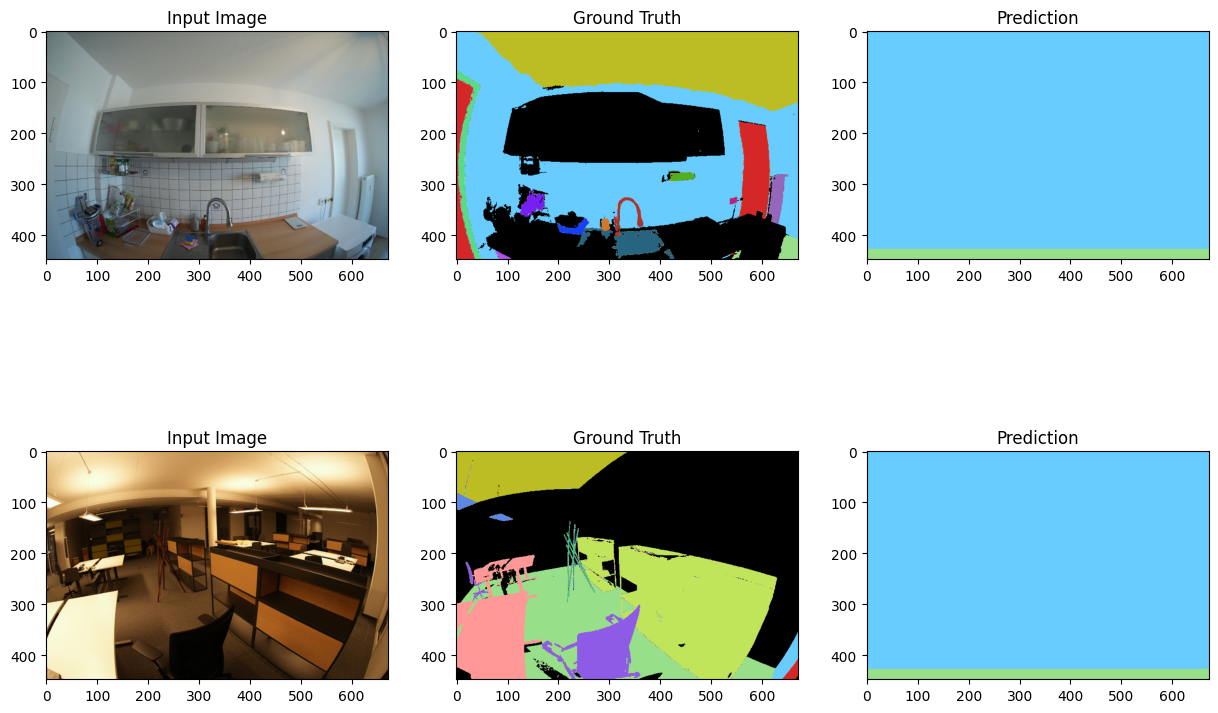

In [ ]:
# Inference and visualize predictions
inference_checkpoint_path = os.path.join(checkpoint_dir, 'checkpoint_epoch_220.pth.tar')
inputs, labels, predictions = inference(model, train_loader, device, num_samples=2)
visualize_predictions(inputs, labels, predictions, palette_file='scripts/utils/palette_scannet200.txt')